In [ ]:
from pathlib import Path
from utils.ocv_data import (
    _load_cluster_cells_from_repo,
    OCVEstimator,
    _load_c_rate_stats,
    process_all_cells,
)

# 1. Build/fit the cluster model directly from the REPT repo
cluster_obj = _load_cluster_cells_from_repo(
    repo_root=Path("/home/kcv/Desktop/REPT_RPT_OCV_analysis"),
    cache_dir=Path("/home/kcv/Desktop/REPT_RPT_OCV_analysis/OCV_analysis"),
    bin_size=0.5,      # use the BIN your cache was built with
    k_clusters=3,      # number of clusters in your model
    embed_dims=3,      # PCA dimensions (match training)
)

estimator = OCVEstimator(cluster_obj)
stats_df = _load_c_rate_stats("/home/kcv/Desktop/Rate_Capability/results/data/c_rate_stats.csv")

# 2. Generate OCV+power CSVs for every cell
output_paths = process_all_cells(
    data_dir="/home/kcv/Desktop/Rate_Capability/Data",
    estimator=estimator,
    stats_df=stats_df,
    soc_dir="/home/kcv/Desktop/Rate_Capability/results/data/soc_data",
    resistance_dir="/home/kcv/Desktop/Rate_Capability/results/data/resistance_data",
    output_dir="/home/kcv/Desktop/Rate_Capability/results/data/ocv_power_data",
)

print(f"Wrote {len(output_paths)} files to /home/kcv/Desktop/Rate_Capability/results/data/ocv_power_data")


/tmp/ipykernel_1269036/2108939107.py:57: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


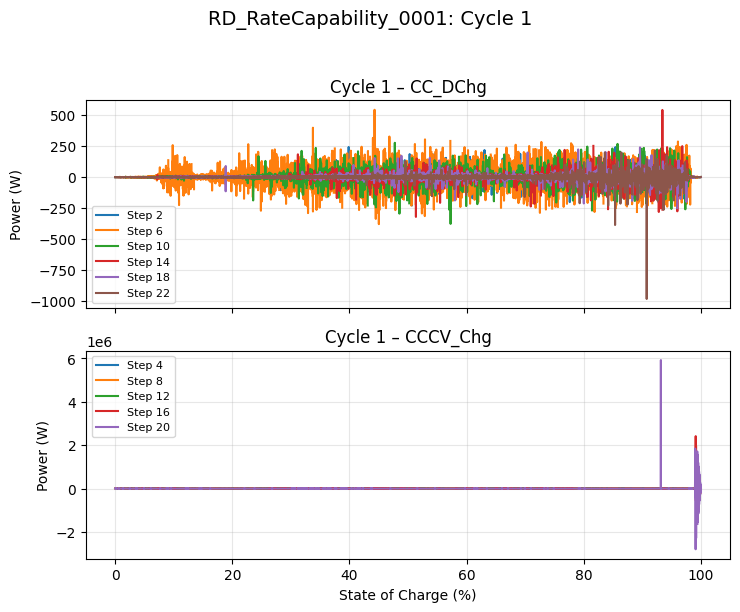

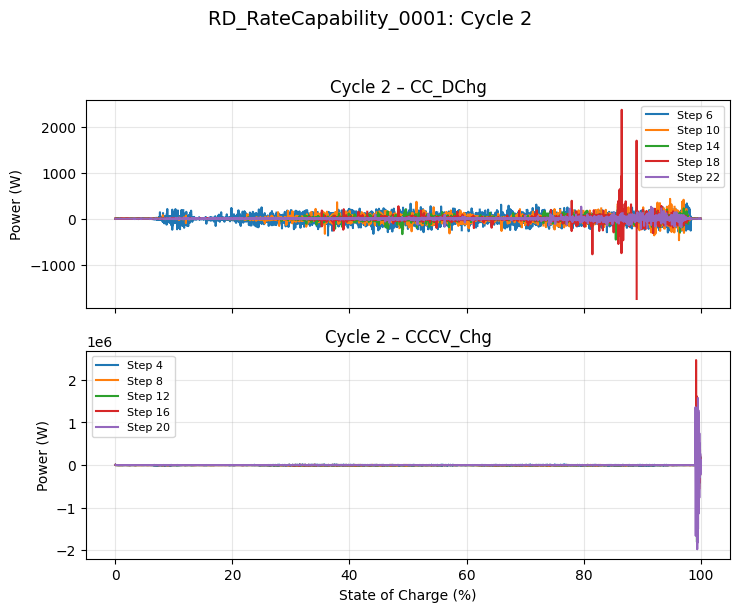

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

OCV_DIR = Path("/home/kcv/Desktop/Rate_Capability/results/data/ocv_power_data")

def plot_cycle_power_cc_steps(cell_name, cycles=None):
    focus_steps = ("CC_DChg", "CCCV_Chg")
    csv_path = OCV_DIR / f"{cell_name}_ocv_data.csv"
    df = pd.read_csv(csv_path)

    if "power(w)" not in df.columns:
        volt = pd.to_numeric(df["volt(v)"], errors="coerce")
        res = pd.to_numeric(df["resistance(ohm)"], errors="coerce")
        df["power(w)"] = np.where(res.abs() > 1e-12, (volt**2) / (4.0 * res), np.nan)

    if cycles is None:
        cycles = sorted(df["cycle no"].dropna().unique())
    else:
        cycles = [c for c in cycles if c in df["cycle no"].values]

    figs = []
    for cycle_no in cycles:
        cycle_df = df[df["cycle no"] == cycle_no]
        if cycle_df.empty:
            continue

        fig, axes = plt.subplots(2, 1, figsize=(7.5, 6.2), sharex=True)
        for ax, step_name in zip(axes, focus_steps):
            mask = cycle_df["step name"].str.strip().str.lower() == step_name.lower()
            step_df = cycle_df[mask]
            if step_df.empty:
                ax.text(0.5, 0.5, f"No {step_name}", ha="center", va="center")
                ax.set_axis_off()
                continue

            for step_no, group in step_df.groupby("step no"):
                ordered = group.sort_values("soc(%)")
                ax.plot(ordered["soc(%)"], ordered["power(w)"], label=f"Step {int(step_no)}")

            ax.set_title(f"Cycle {cycle_no} – {step_name}")
            ax.set_ylabel("Power (W)")
            ax.grid(alpha=0.3)
            ax.legend(fontsize=8)

        axes[-1].set_xlabel("State of Charge (%)")
        fig.suptitle(f"{cell_name}: Cycle {cycle_no}", fontsize=14, y=0.98)
        fig.tight_layout(rect=[0, 0, 1, 0.95])
        figs.append(fig)

    return figs

# Example
figures = plot_cycle_power_cc_steps("RD_RateCapability_0001", cycles=[1, 2])
for fig in figures:
    fig.show()


In [8]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from pathlib import Path

OCV_DIR = Path("/home/kcv/Desktop/Rate_Capability/results/data/ocv_power_data")
PDF_OUT = Path("/home/kcv/Desktop/Rate_Capability/results/plots/soc_power_bars.pdf")

def soc_power_bars_by_c_rate(
    cell_name: str,
    steps=("CC_DChg", "CCCV_Chg"),
    cycles=None,
    soc_bin=5,
):
    csv_path = OCV_DIR / f"{cell_name}_ocv_data.csv"
    df = pd.read_csv(csv_path)

    if "power(w)" not in df.columns:
        volt = pd.to_numeric(df["volt(v)"], errors="coerce")
        res = pd.to_numeric(df["resistance(ohm)"], errors="coerce")
        df["power(w)"] = np.where(res.abs() > 1e-12, (volt**2) / (4 * res), np.nan)
    df["power(w)"] = df["power(w)"].abs()

    if cycles is not None:
        df = df[df["cycle no"].isin(cycles)]

    df["soc_bin"] = (df["soc(%)"] // soc_bin * soc_bin).astype(int)

    fig, axes = plt.subplots(len(steps), 1, figsize=(9, 3.5 * len(steps)), sharex=True)
    axes = np.atleast_1d(axes)

    for ax, step in zip(axes, steps):
        mask = df["step name"].str.strip().str.lower() == step.strip().lower()
        subset = df[mask]
        if subset.empty:
            ax.text(0.5, 0.5, f"No data for {step}", ha="center", va="center")
            ax.set_axis_off()
            continue

        # mean c-rate per step no (used for legend labels)
        c_rate_lut = (
            subset.groupby("step no")["c_rate"]
            .mean()
            .apply(lambda val: f"{abs(val):.2f}C" if pd.notna(val) else "Unknown")
        )

        pivot = (
            subset.groupby(["soc_bin", "step no"])["power(w)"]
            .mean()
            .unstack(fill_value=np.nan)
            .sort_index()
        )

        n_steps = pivot.shape[1]
        width = soc_bin * 0.8 / max(1, n_steps)
        offsets = np.linspace(-width * n_steps / 2, width * n_steps / 2, n_steps, endpoint=False)

        for offset, (step_no, series) in zip(offsets, pivot.items()):
            label = c_rate_lut.get(step_no, f"Step {int(step_no)}")
            ax.bar(
                pivot.index + offset,
                series.values,
                width=width,
                label=label,
            )

        ax.set_title(f"{cell_name} – {step}")
        ax.set_ylabel("|Power| (W)")
        ax.grid(alpha=0.2, axis="y")
        ax.legend(fontsize=8, ncol=min(3, n_steps))

    axes[-1].set_xlabel("SoC bin (%)")
    fig.tight_layout()
    return fig

pdf_out = PDF_OUT
pdf_out.parent.mkdir(parents=True, exist_ok=True)

with PdfPages(pdf_out) as pdf:
    for csv_path in sorted(OCV_DIR.glob("*_ocv_data.csv")):
        cell_name = csv_path.stem.replace("_ocv_data", "")
        fig = soc_power_bars_by_c_rate(
            cell_name,
            steps=("CC_DChg", "CCCV_Chg"),
            cycles=None,     # or e.g. [1, 5, 10]
            soc_bin=10,
        )
        pdf.savefig(fig)
        plt.close(fig)

print(f"Saved SoC-power bar charts for {len(list(OCV_DIR.glob('*_ocv_data.csv')))} cells to {pdf_out}")


Saved SoC-power bar charts for 21 cells to /home/kcv/Desktop/Rate_Capability/results/plots/soc_power_bars.pdf
